In [1]:
import train as tn
reload(tn)

import plotting
reload(plotting)

import util as ut

import matplotlib.pyplot as plt
from matplotlib import ticker

import numpy as np

from pprint import pprint

import itertools
import time

import os

from collections import OrderedDict

import effPlotwidget as effplt

Welcome to ROOTaaS 6.06/08


In [2]:
dataDir = './data'
inputName = '3clfs'#'1clf_GenIsoAdded'
inputDir = './classifiers'

In [3]:
proj_variables = ['genPt','absGenRapidity']#,'genLeadGenIso','genSubleadGenIso']

In [4]:
ut.defaultParameters(dataDir=dataDir, inputName=inputName, inputDir=inputDir)
ut.setParams()
ut.params['genBranches'] = ['genPt', 'genRapidity', 'genJet2p5Pt0', 'genJet2p5Rapidity0',
                            'genJet2p5Pt1', 'genJet2p5Rapidity1', 'genJet2p5Pt2', 'genJet2p5Rapidity2', 
                            'genJet2p5Pt3', 'genJet2p5Rapidity3', 'weight', 'genNjets2p5']
effFitter = ut.loadOrMake()

entered config files named my_train_config
hi
None
Load object with the name 3clfs and the following paramters 
loading
3clfs
./classifiers
./classifiers
./classifiers/3clfs.pkl.gz
loading pickle ./classifiers/3clfs.pkl.gz
loading data ./classifiers/3clfs.root
Index([u'absweight', u'class', u'genJet2p5Pt0', u'genJet2p5Pt1',
       u'genJet2p5Pt2', u'genJet2p5Pt3', u'genJet2p5Rapidity0',
       u'genJet2p5Rapidity1', u'genJet2p5Rapidity2', u'genJet2p5Rapidity3',
       u'genNjets2p5', u'genPt', u'genRapidity', u'recoNjets2p5', u'recoPt',
       u'recoRapidity', u'weight', u'proc', u'absGenRapidity',
       u'absGenJet2p5Rapidity0', u'absGenJet2p5Rapidity1',
       u'absGenJet2p5Rapidity2', u'absGenJet2p5Rapidity3', u'recoPtBin',
       u'recoPtCat', u'recoNjets2p5Bin', u'recoNjets2p5Cat', u'class_prob_0',
       u'class_prob_1', u'class_prob_2', u'class_prob_3', u'recoPtCat_prob_0',
       u'recoPtCat_prob_1', u'recoPtCat_prob_2', u'recoPtCat_prob_3',
       u'recoPtCat_prob_4', u'recoP

In [5]:
def weighted_average(df_name, column_name, weight_name=None):
    """
        This function computes the weighted average of the quantity column_name
        stared in the pandas dataframe df_name. In case no weights are given
        or if they sum up to zero, the mean is returned instead.
        :params 
                df_name :
            column_name :
            weight_name :
        :retruns
                        :
        """
    #----------------------------------------------------------------------------
    d = df_name[column_name]
    w = df_name[weight_name]
    if (weight_name == None) :
        return float(d.mean())
    else :
        try:
            return (d * w).sum() / float(w.sum())
        except ZeroDivisionError:
            return float(d.mean())
    #----------------------------------------------------------------------------

def weight_freq (df_name, column_name, equal_to, weight_name, err=False) :
    #----------------------------------------------------------------------------

    df = df_name#[df_name[column_name]==equal_to]

    w_all = df[weight_name].sum()
    w_PartPhaseSpace = df[df[column_name] == equal_to][weight_name].sum()
    
    ratio = w_PartPhaseSpace / w_all
    
    if err :
        #calculate estimated error on this ratio using a Poisson and Gaussian error propagation
        w_all_errSquared = (df[weight_name]**2).sum()
        w_PartPhaseSpace_errSquared = (df[df[column_name] == equal_to][weight_name]**2).sum()
        #print (w_all_errSquared)
        #print(w_PartPhaseSpace_errSquared)
        #print(w_all**2)
        #rint(w_PartPhaseSpace**2)
        if (w_PartPhaseSpace == 0) :
            #print('sum of weights zero')
            return 0.#'NoEv'
        else :
            #ratio_err = np.sqrt(w_PartPhaseSpace_errSquared / w_PartPhaseSpace**2)
            ratio_err = np.sqrt(w_all_errSquared/w_all**2 + w_PartPhaseSpace_errSquared / w_PartPhaseSpace**2)
        #print(np.shape(ratio_err))
        #print(ratio_err)
            return ratio_err
    else :
        return ratio
    #----------------------------------------------------------------------------

In [6]:
#x_var = 'genLeadGenIso'
#y_var = 'genSubleadGenIso'
bins_dict = { 'genPt'        : dict(boundaries=[0.,15.,30.,45.,85.,125.,200.,350.]), 
            'absGenRapidity' : dict(boundaries=[0.,0.05,0.1,0.15,0.2,0.5,0.75,1.,1.5,2.,2.5]),
             #'genLeadGenIso' :    dict(boundaries=[0.,0.1,0.3,0.5,1.,2.,3.,5.,7.]),
             #'genSubleadGenIso' : dict(boundaries=[0.,0.1,0.3,0.5,1.,2.,3.,5.,7.])
                 
             }
ut.runDefineBins(effFitter,bins_dict)

In [7]:
df_initial = effFitter.df
first_train_evt = int(round(df_initial.index.size*(1.-effFitter.split_frac)))
#take the test sample 
df_test_initial = df_initial[:first_train_evt]

In [8]:
# take ttH sample
df_ttH = df_initial[df_initial['proc']==1]
df_ttH_test = df_test_initial[df_test_initial['proc']==1]


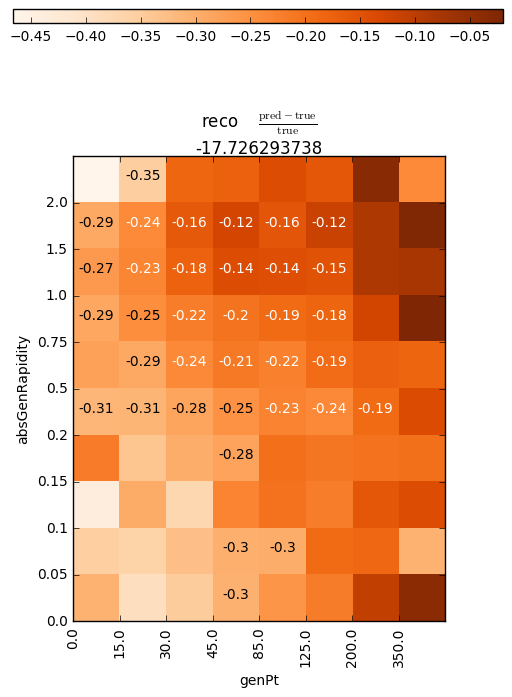

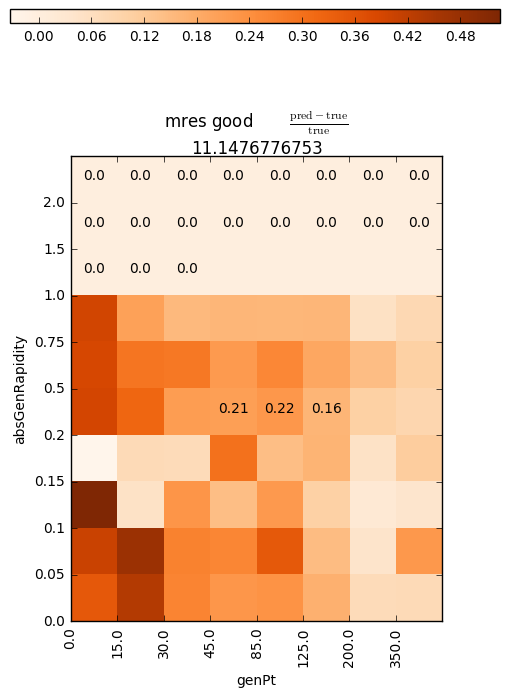

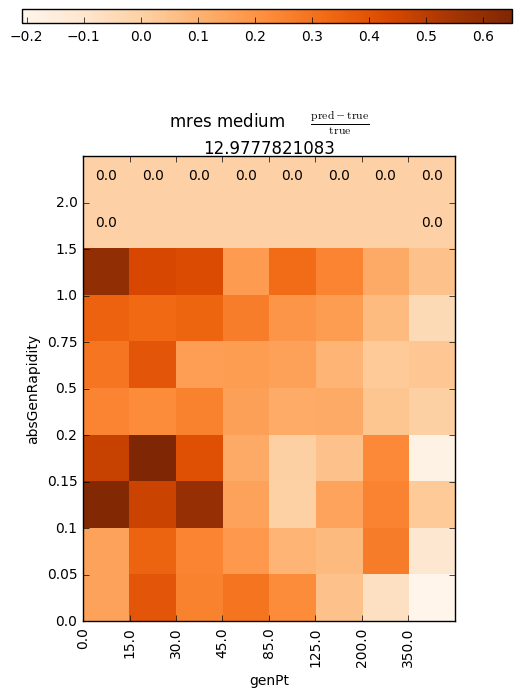

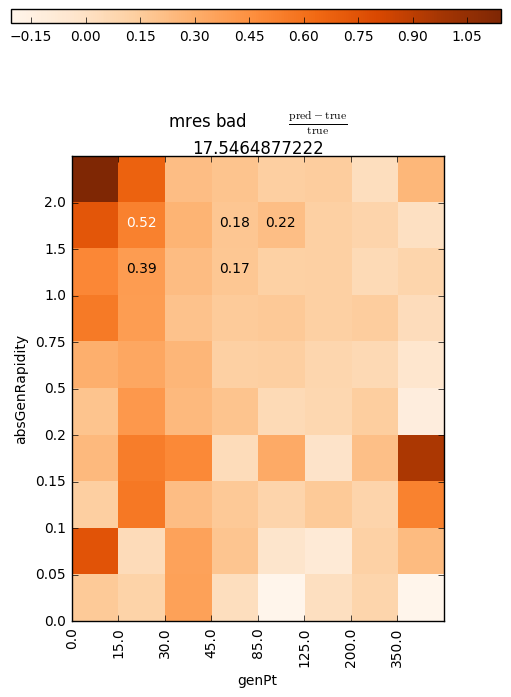

In [9]:
reload(effplt)
for x_var, y_var in itertools.combinations(proj_variables,2) :
    
    saveName = x_var+'_vs_'+y_var+'/'
    savePath = '/mnt/t3nfs01/data01/shome/jandrejk/higgs_model_dep/plots/ttH_PhaseSpaceCuts_20PercentCut_old/'
    directory = savePath+saveName

    if not os.path.exists(directory):
        os.makedirs(directory)
        
    mres = ['good','medium','bad']
    # watch out class 0 correspnds to prob 1
    for i in np.arange(0,4,1) :
        #print i
        gb_freq = df_ttH.groupby([x_var+'Bin',y_var+'Bin']).apply(weight_freq,"class",(i-1),'absweight',err=False)
        gb_freq_err = df_ttH.groupby([x_var+'Bin',y_var+'Bin']).apply(weight_freq,"class",(i-1),'absweight',err=True)
        
        
        gb_proba = df_ttH_test.groupby([x_var+'Bin',y_var+'Bin']).apply(weighted_average, 'class_prob_'+str(i),'absweight')
        if (i == 0) :
            effplt.plotRelDiff_imshow(groupby_objects=[gb_proba,gb_freq],
                                      true_err = gb_freq_err,
                                      binBoundaries=bins_dict, 
                                      x_lab=x_var,
                                      y_lab=y_var,
                                        cmap=plt.cm.Oranges,
                                      title='reco \t',
                                savepath=None,#directory+'reco_eff',
                               )
        else :
            effplt.plotRelDiff_imshow(groupby_objects=[gb_proba,gb_freq],
                                      true_err = gb_freq_err,
                                      binBoundaries=bins_dict, 
                                      x_lab=x_var,
                                      y_lab=y_var,
                                      cmap=plt.cm.Oranges,
                               title='mres '+mres[i-1]+'\t',
                                savepath=None,#directory+'mres_'+mres[i-1],
                               )


In [55]:
#for i in np.arange(0,4,1) :
 
i = 3 

x_var = 'genPt'
y_var = 'absGenRapidity'

gb_freq_abs = df_ttH.groupby([x_var+'Bin',y_var+'Bin']).apply(weight_freq,"class",(i-1),'absweight',err=False)
gb_freq_err_abs = df_ttH.groupby([x_var+'Bin',y_var+'Bin']).apply(weight_freq,"class",(i-1),'absweight',err=True)


gb_proba_abs = df_ttH_test.groupby([x_var+'Bin',y_var+'Bin']).apply(weighted_average, 'class_prob_'+str(i),'absweight')

gb_freq = df_ttH.groupby([x_var+'Bin',y_var+'Bin']).apply(weight_freq,"class",(i-1),'weight',err=False)
gb_freq_err = df_ttH.groupby([x_var+'Bin',y_var+'Bin']).apply(weight_freq,"class",(i-1),'weight',err=True)


gb_proba = df_ttH_test.groupby([x_var+'Bin',y_var+'Bin']).apply(weighted_average, 'class_prob_'+str(i),'weight')


In [56]:
def GetMatrix (gb) :
    x,y = gb.index.levels
    cm = gb.values.reshape(len(x),len(y))
    return cm.T

In [57]:
freq_mat_abs = GetMatrix(gb_freq_abs).ravel()
freq_mat_err_abs = GetMatrix(gb_freq_err_abs).ravel()
freq_mat = GetMatrix(gb_freq).ravel()
freq_mat_err = GetMatrix(gb_freq_err).ravel()

In [58]:
x_axis = np.arange(len(freq_mat))

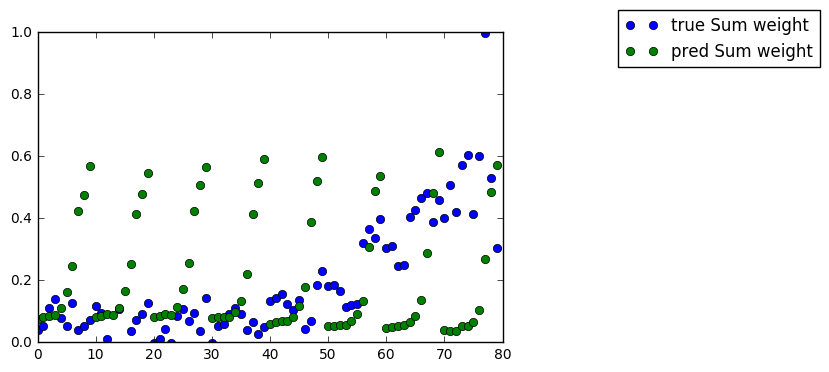

In [77]:
ax = plt.subplot(111)


plt.plot(x_axis,freq_mat,'bo',label='true Sum weight')
#plt.plot(x_axis,freq_mat_abs,'ro',label='true Sum absweight')
plt.plot(x_axis,gb_proba,'go',label='pred Sum weight')

#plt.plot(x_axis,freq_mat_err,'b-',label='error true Sum weight')
#plt.plot(x_axis,freq_mat_err_abs,'r-',label='error true Sum absweight')
plt.ylim(0,1)
ax.legend(bbox_to_anchor=(1.7, 1.1))
plt.show()

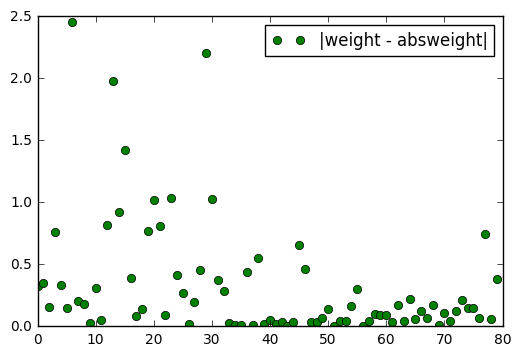

In [64]:
plt.plot(x_axis,abs(freq_mat-freq_mat_abs)/abs(freq_mat_abs),'go',label='|weight - absweight|')
plt.legend(loc='best')
plt.show()

In [54]:
r = np.random.randn(100)
#plt.plot(np.arange(1000),r,'bo')
#plt.show()

one_sig = 0
two_sig = 0
three_sig =0

for q in r :
    if(abs(q)>=1) :
        one_sig += 1
    if(abs(q)>=2) :
        two_sig += 1
    if(abs(q)>=3) :
        three_sig += 1

print(one_sig)
print(two_sig)
print(three_sig)


31
6
0
